
Neural networks are known to "trick" us by exploiting unobvious shortcuts to achieve good performance (e.g., when tasked with recognizing if a wolf or a dog is on the image, they could learn to recognize the features of terrain instead).  Convolutional Neural Networks (CNN) are extremely useful in image classification tasks. They recognize patterns in the data by encoding various features in the images such as edges, lines, circles.
We hope a neural network to depend solely on pixels it sees, but... position information might be useful as well.

Can a CNN recover information about the position of each pixel just from pixel values and padding? In this task, you will verify this hypothesis.

You have to implement a CNN model which will predict the position of each pixel (the x or y coordinate normalized to [0,1]) using convolutional layers.



The ideal model would output something like this: 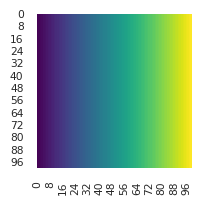

In [130]:
import torch.nn.functional as F
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


# Implement SimpleConvnet (5p)
This model consist of two parts:
- a parametrized number of blocks
- linear projection

Each block should have two layers: *convolution* and *relu*. The number of blocks is parametrized by the **n_convolutions** argument. All convolutions layers **in blocks** should have a kernel_size equal to 3 and padding equal to 1.

The input to the model has the shape: (batch_size, 1, spatial_dimension, spatial_dimension), so it starts with only 1 channel (filter). First 4 blocks should double the number of channels. Blocks from index 4 upward should keep the number of channels (filters) unchanged.

Linear projection should decrease the number of channels to 1. Therefore, the output of the model should match the input in shape.

In [131]:
class SimpleConvnet(nn.Module):
    def __init__(self, n_convolutions):
        super(SimpleConvnet, self).__init__()
        # TODO
        self.n_convolutions = n_convolutions
        self.in_channels = 1
        
        self.blocks = self._generate_convnet_blocks()
        self.projection = nn.Conv2d(in_channels=self.in_channels, out_channels=1, kernel_size=1)

    def _generate_convnet_blocks(self):
        blocks = nn.ModuleList()
        
        for _ in range(min(4, self.n_convolutions)):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channels, out_channels=2 * self.in_channels, kernel_size=3, padding=1),
                nn.ReLU()
            )
            blocks.append(conv_block)
            self.in_channels *= 2
        
        for _ in range(4, self.n_convolutions):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=3, padding=1),
                nn.ReLU()
            )
            blocks.append(conv_block)
            
        return blocks
        # END TODO

    def forward(self, x):
      # TODO
        for block in self.blocks:
            x = block(x)
        x = self.projection(x)
        return x
      # END TODO


## Helper functions

In [132]:
def visualize(array):
  plt.figure(figsize=(2,2))
  sns.set(font_scale=0.7)
  sns.heatmap(array, cmap='viridis', cbar=False, annot=False)
  plt.show()

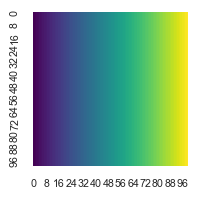

In [133]:
def generate_spectrum(spatial_dimension):
  row = torch.linspace(0, 1, spatial_dimension)
  return row.expand(spatial_dimension, -1)
spectrum = generate_spectrum(100)
visualize(spectrum.numpy())

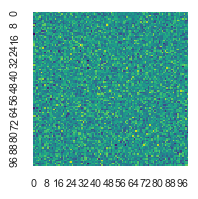

In [134]:
def generate_noise(batch_size, spatial_dimension):
  return torch.randn(batch_size, 1, spatial_dimension, spatial_dimension)
visualize(generate_noise(1,100)[0].squeeze().numpy())

## Training (1p)
Implement target preparation.

In [135]:

def train(epochs, steps, batch_size, model, optimizer, spatial_dimension, verbose=1):
    model.train()

    # TODO
    # Prepare target (it will be the same in every sample)
    target = generate_spectrum(spatial_dimension).unsqueeze(0).unsqueeze(0).expand(batch_size, -1, -1, -1)
    
    # ENDTODO
    assert target.shape == torch.Size([batch_size, 1, spatial_dimension, spatial_dimension])

    for epoch in range(epochs):
        running_loss = 0
        for i in range(steps):
            noise = generate_noise(batch_size, spatial_dimension)
            predicted = model(noise)
            loss = F.mse_loss(predicted, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose > 0:
          print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, epochs, running_loss / steps))
          with torch.no_grad():
            input = generate_noise(1, spatial_dimension)
            predicted_gradient = model(input)[0].numpy()
            visualize(predicted_gradient.squeeze(0))

Epoch [1/20], Loss: 0.2559


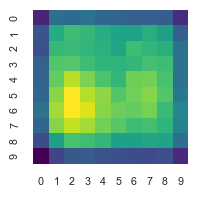

Epoch [2/20], Loss: 0.0928


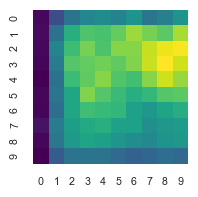

Epoch [3/20], Loss: 0.0417


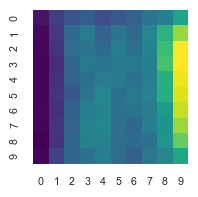

Epoch [4/20], Loss: 0.0239


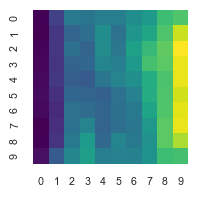

Epoch [5/20], Loss: 0.0191


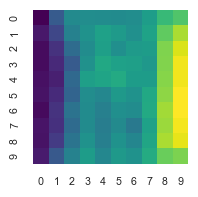

Epoch [6/20], Loss: 0.0163


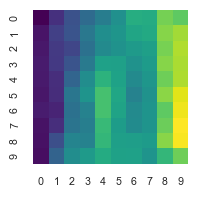

Epoch [7/20], Loss: 0.0139


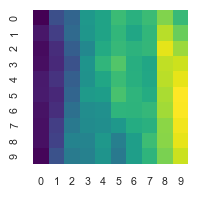

Epoch [8/20], Loss: 0.0119


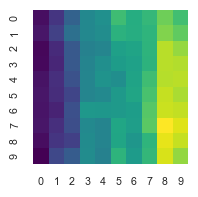

Epoch [9/20], Loss: 0.0104


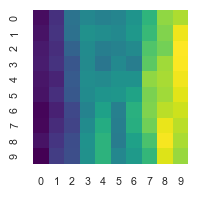

Epoch [10/20], Loss: 0.0094


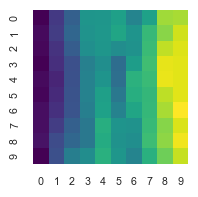

Epoch [11/20], Loss: 0.0085


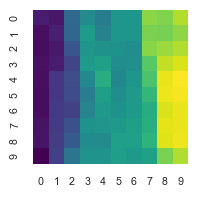

Epoch [12/20], Loss: 0.0078


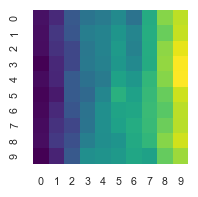

Epoch [13/20], Loss: 0.0073


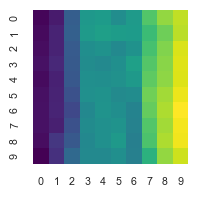

Epoch [14/20], Loss: 0.0068


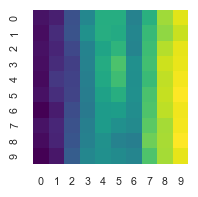

Epoch [15/20], Loss: 0.0064


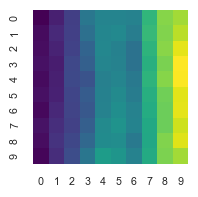

Epoch [16/20], Loss: 0.0060


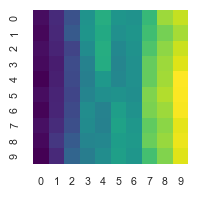

Epoch [17/20], Loss: 0.0058


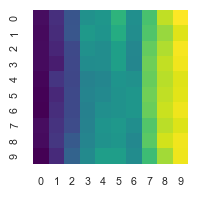

Epoch [18/20], Loss: 0.0056


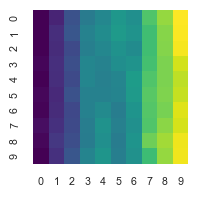

Epoch [19/20], Loss: 0.0054


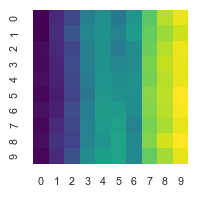

Epoch [20/20], Loss: 0.0053


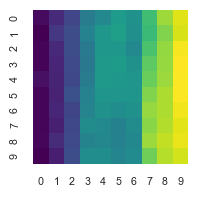

In [136]:
# Check if training works
# do not exceed n_convolutions = 10 and spatial_dimension = 20
n_convolutions = 4 #  TODO
spatial_dimension = 10 # TODO
epochs = 20
steps = 50

model = SimpleConvnet(n_convolutions)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(epochs=epochs, steps=steps, batch_size=256, model=model, optimizer=optimizer, spatial_dimension=spatial_dimension, verbose=1)

## Experiments (5p)

Create two lists:
- *n_convolutions_params* with 4 different values (suggested [2, 4, 6, 8])
- *spatial_dimensions_params* with 4 different values (suggested [5,10,15,20])

For each pair (n_convolutions,spatial_dimensions) $\in$ (n_convolutions_params $\times$ spatial_dimensions_param), train a model with these parameters and visualize the prediction of the trained model on a sampled noise.

Represent these vizualizations on image grid of shape 4 $\times$ 4. Explain these results.

(Note: do not exceed n_convolutions = 10 and spatial_dimension = 20. It takes about 2min on CPU to train model with these parameters. )

(Note2: *visualize* function runs plt.show() so it can interfere with image grid. You can disable it by changing verbose argument in *train* to 0.)


Computation for n_convolutions=2 and spatial_dimension=5 done
Computation for n_convolutions=2 and spatial_dimension=10 done
Computation for n_convolutions=2 and spatial_dimension=15 done
Computation for n_convolutions=2 and spatial_dimension=20 done
Computation for n_convolutions=4 and spatial_dimension=5 done
Computation for n_convolutions=4 and spatial_dimension=10 done
Computation for n_convolutions=4 and spatial_dimension=15 done
Computation for n_convolutions=4 and spatial_dimension=20 done
Computation for n_convolutions=6 and spatial_dimension=5 done
Computation for n_convolutions=6 and spatial_dimension=10 done
Computation for n_convolutions=6 and spatial_dimension=15 done
Computation for n_convolutions=6 and spatial_dimension=20 done
Computation for n_convolutions=8 and spatial_dimension=5 done
Computation for n_convolutions=8 and spatial_dimension=10 done
Computation for n_convolutions=8 and spatial_dimension=15 done
Computation for n_convolutions=8 and spatial_dimension=20 d

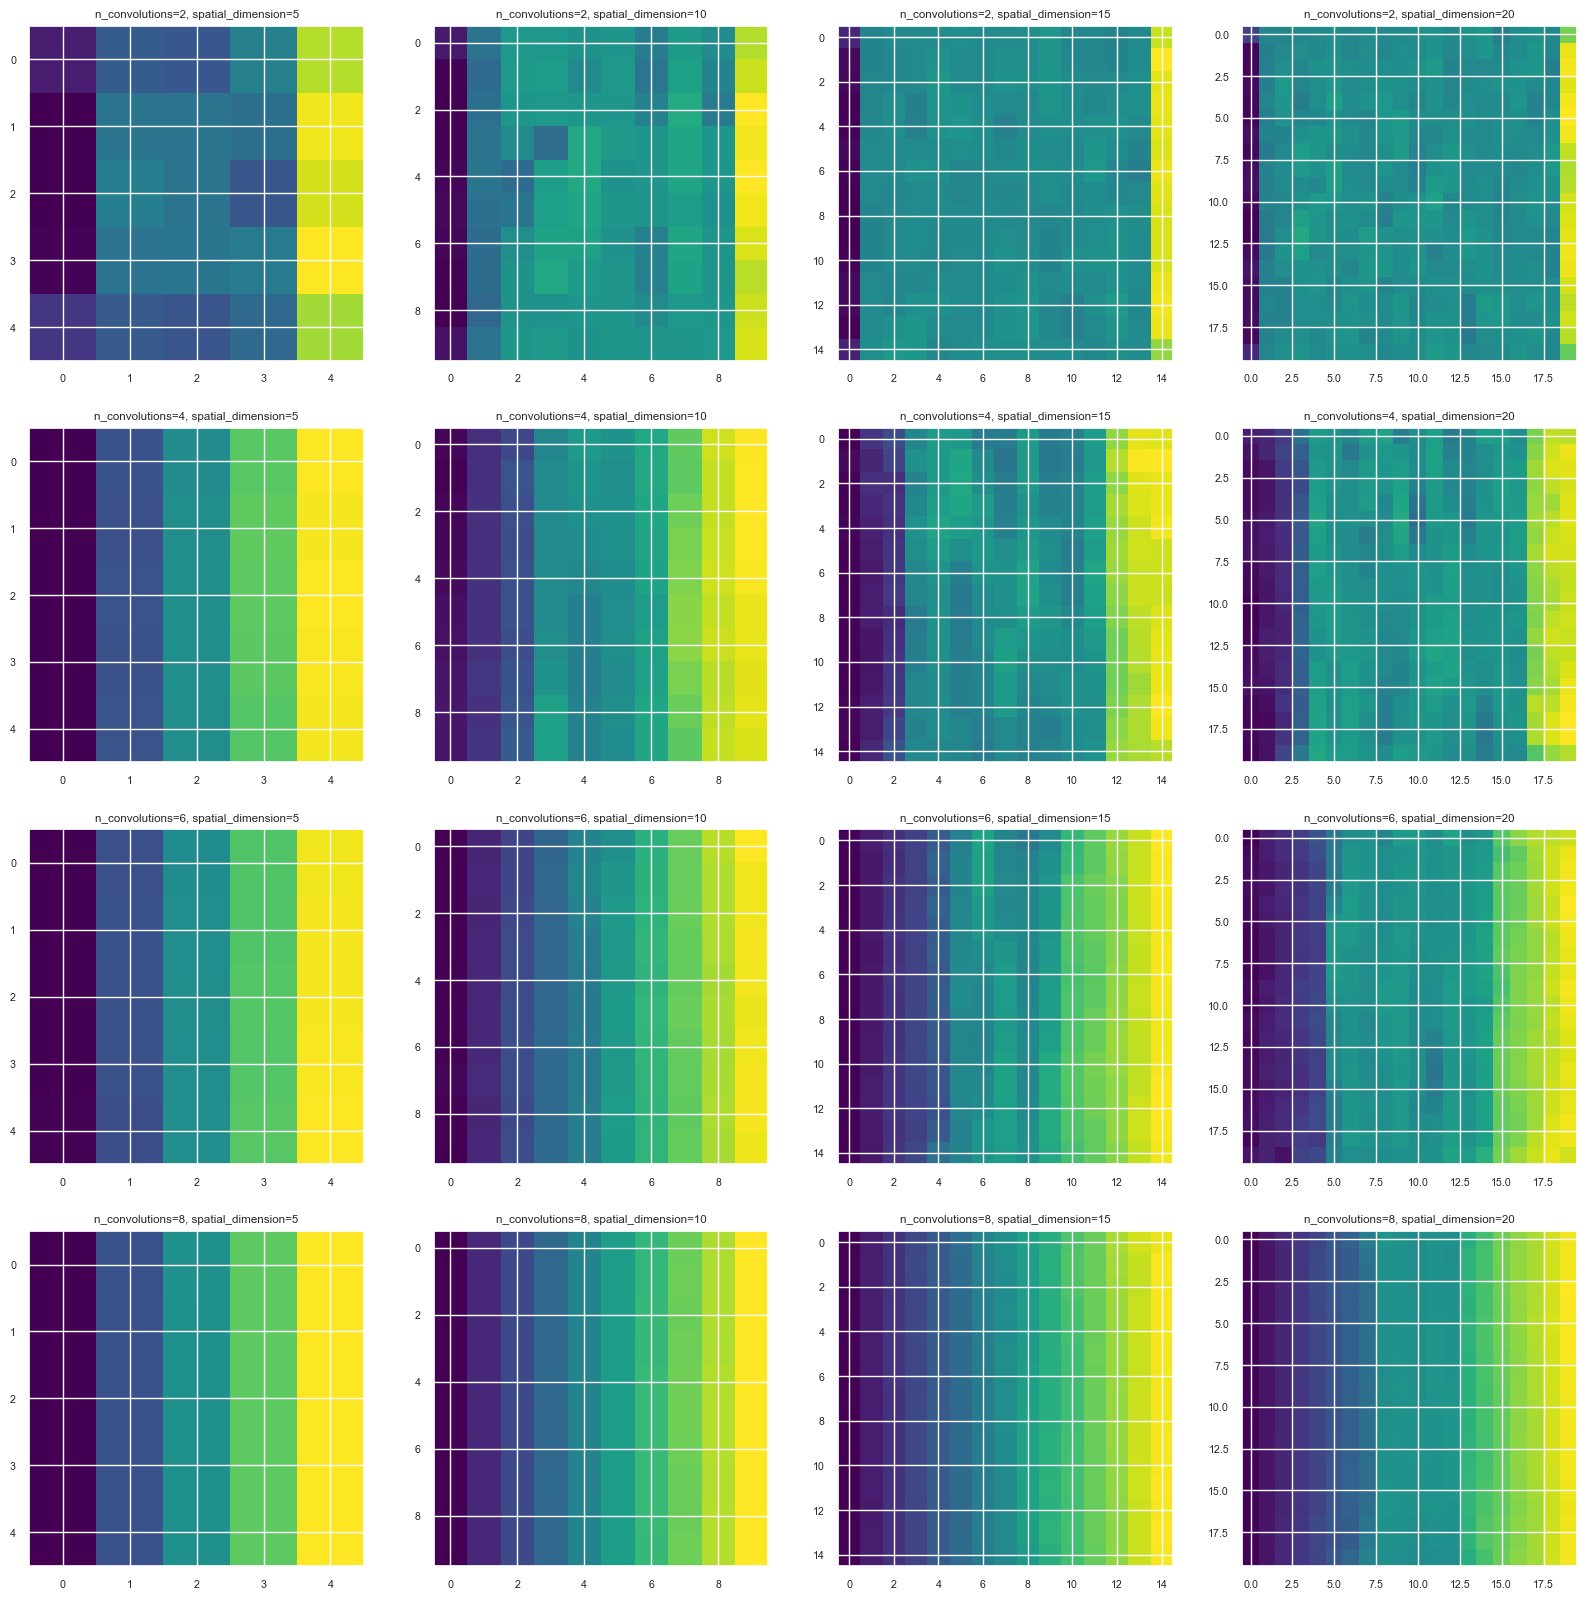

In [138]:
#TODO
n_convolutions_params = [2, 4, 6, 8]
spatial_dimensions_params = [5,10,15,20]

# Grid 4x4 of visualizations
fig, axs = plt.subplots(len(n_convolutions_params), len(spatial_dimensions_params), figsize=(20, 20))

for i, n_convolutions in enumerate(n_convolutions_params):
    for j, spatial_dimension in enumerate(spatial_dimensions_params):
        model = SimpleConvnet(n_convolutions)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train(epochs=epochs, steps=steps, batch_size=256, model=model, optimizer=optimizer, spatial_dimension=spatial_dimension, verbose=0)
        
        with torch.no_grad():
            noise = generate_noise(1, spatial_dimension)
            prediction = model(noise)[0]
            axs[i, j].imshow(prediction.squeeze().detach().numpy(), cmap='viridis')
            axs[i, j].set_title(f"n_convolutions={n_convolutions}, spatial_dimension={spatial_dimension}")
            
        print(f"Computation for n_convolutions={n_convolutions} and spatial_dimension={spatial_dimension} done")

plt.show()
# END TODO

# Explain the results

(sorry for not deleting the grid on each plot :( )

As we can see on the 4x4 visualisation grid for each n_convolutions and spatial_dimension, the bigger model we create, with more numbers of convolutions the better it predicts the position for each pixel, even for higher spatial dimensions, as we can see for small number of n_convolutions and big number of spatial_dimensions, the model can barely predict the space well. As the size of model increase it will take definitely more time to train, as mentioned above for n_convolutions = 10 and spatial_dimensions = 20, but for bigger n_convolutions it can give better and better results as we can notice on the visualisation grid, that as n_convolutions increase along with the spatial_dimension it gives better results for the left and right side of the image. So the bigger model the better it is able to predict the spectrum of the noise. The more convolutions and the higher spatial dimension, the more accurate the prediction is.
